<div>
    <center>
        <h1>
            <font color="#902e59">CQF June 2023 Intake: Final Project</font>
        </h1>
    </center>
    <center>
        <h3>Deep Learning for Asset Prediction</h3>
    </center>
    <center>
        <h5>Will Colgate, Singapore, January 2024</h5>
    </center>
    <center>
        <a href='https://github.com/will-j-c/cqf_final_project_DL'>
            <svg height="32" aria-hidden="true" viewBox="0 0 16 16" width="32">
            <path d="M8 0c4.42 0 8 3.58 8 8a8.013 8.013 0 0 1-5.45 7.59c-.4.08-.55-.17-.55-.38 0-.27.01-1.13.01-2.2 0-.75-.25-1.23-.54-1.48 1.78-.2 3.65-.88 3.65-3.95 0-.88-.31-1.59-.82-2.15.08-.2.36-1.02-.08-2.12 0 0-.67-.22-2.2.82-.64-.18-1.32-.27-2-.27-.68 0-1.36.09-2 .27-1.53-1.03-2.2-.82-2.2-.82-.44 1.1-.16 1.92-.08 2.12-.51.56-.82 1.28-.82 2.15 0 3.06 1.86 3.75 3.64 3.95-.23.2-.44.55-.51 1.07-.46.21-1.61.55-2.33-.66-.15-.24-.6-.83-1.23-.82-.67.01-.27.38.01.53.34.19.73.9.82 1.13.16.45.68 1.31 2.69.94 0 .67.01 1.3.01 1.49 0 .21-.15.45-.55.38A7.995 7.995 0 0 1 0 8c0-4.42 3.58-8 8-8Z"></path>
        </a>
    </center>
</svg>
</div>


### Problem Statement
The objective is to produce a model that can predict positive moves using Long Short-Term Memory (LSTM) networks.

I have chosen Ethereum (ETH) as the ticker to analyse (technically a pair with USD). Crypto markets are notoriously volatile and it seems like a decent challenge to try and tease some insight out of the mess.

For this purpose, I will aim to predict an hourly positive return. Defining a positive return is discussed in more detail as part of the labels section. This will be a binary classification problem with accuracy as the main metric used to measure the effectiveness of the model. The baseline to test the effectiveness fo the model against would be a random guess (i.e. a 50% chance of being correct) and the baseline for a strategy based on this prediction would be to buy on day one and hold until the end of the test period.

In [1]:
# Imports
from src.config import *

# Base
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_row', 500)
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Feature engineering
import pandas_ta as ta

# Warnings
import warnings
warnings.filterwarnings("ignore")

### Data Collection

##### Raw Data

Using `download.py`, I have downloaded two years worth of hourly ticker data. This script wraps a simple function that pulls data from `yfinance`. The data is saved locally in "ETH-USD_2y_1h.csv" for convenience.

`yfinance` has a restriction on the amount of hourly data that can be downloaded and restricts this to 730 days of data (i.e. 2 years). Given crypto markets never close, this amounts to 17k+ data points. As a general rule of thumb, 5 years of daily data would be required to predict daily returns. On a normal security, this would only be approximately 1,300 data points. Therefore, 2 years of hourly data should be more than sufficient for this problem. In fact, the amount of data may need to be reduced due to hardware constraints.

In [2]:
# Collect the data into a dataframe
csv = 'data/raw/ETH-USD_2y_1h.csv'
df = pd.read_csv(csv, index_col='Datetime', parse_dates=True)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,17485.0,1.940922e+03,6.728440e+02,902.475952,1559.277222,1784.905029,2.040799e+03,4.205823e+03
High,17485.0,1.947399e+03,6.756417e+02,921.278198,1564.480469,1790.515625,2.048271e+03,4.227112e+03
Low,17485.0,1.934211e+03,6.697479e+02,896.300049,1553.950684,1778.494019,2.032429e+03,4.156187e+03
Close,17485.0,1.940835e+03,6.726981e+02,896.575623,1559.341064,1784.716431,2.040379e+03,4.204396e+03
Volume,17485.0,1.633657e+08,4.769001e+09,0.000000,0.000000,0.000000,1.216338e+08,6.273375e+11
Dividends,17485.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
Stock Splits,17485.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00


The above looks fairly standard for data from `yfinance`. Immediately we can drop Dividends and Stock Splits given this is a crypto token and the entries are all zero in the data.

There appear to be large range of volumes (including nil volumes).

In [3]:
# Looking at the zero volume entries
df['Volume'][df['Volume'] == 0].count()

9100

The above suggests the volume data is unreliable given it is unlikely there were 375 days (i.e. 9,100 hours) where not a single transactions was registered. 

Therefore, I looked for an alternative datasource and found [www.cryptodatadownload.com]() which has hourly data for Gemini, a fairly reputable exchange. I can't speak for the source of the data and it's accuracy but the Gemini API itself only serves data for the past two months, which is unlikely to be enough. For the sake of this experiment, I will use the csv data downloaded from the website. In production, more reliable data straight from the exchange should be procured before making any investment decisions with real money.

The hourly data is expressed in New York East Coast time.

In [4]:
df = pd.read_csv('data/raw/Gemini_ETHUSD_1h.csv', skiprows=[0])
# Parse unix timestamp as UTC dates
df['unix'] = pd.to_datetime(df['unix'], unit='ms', utc=True)
df.set_index(df['unix'], inplace=True)
# Drop date, symbol and Volume USD columns
df.drop(['unix', 'date', 'symbol', 'Volume ETH'], axis=1, inplace=True)
# Rename
df.rename(columns={'Volume USD': 'volume'}, inplace=True)
# Sort date ascending
df.sort_index(inplace=True)
# Take the last 2.5 years to account for losses NaN when feature engineering begins
df = df['2021-6-13':]
df.head()

,open,high,low,close,volume
unix,,,,,
2021-06-13 00:00:00+00:00,2370.80,2395.82,2353.41,2390.15,1.366545e+06
2021-06-13 01:00:00+00:00,2390.15,2419.83,2389.32,2412.34,7.737279e+05
2021-06-13 02:00:00+00:00,2412.34,2416.56,2380.05,2384.52,4.729696e+05
2021-06-13 03:00:00+00:00,2384.52,2384.85,2315.00,2336.26,7.616922e+06
2021-06-13 04:00:00+00:00,2336.26,2347.56,2326.20,2342.47,9.005220e+05


In [5]:
# Plotting closing price and volume
# plot_price_vol(df, 'close', 'volume')

The new data looks much more reasonable and seems to include more data points for volatility. There is also much more data availably, which should hopefully help with training the model. Again, I may need to remove some of this data due to hardware limitations. I will use this going forwards.

The crypto market is notoriously emotion driven. Even glancing at social maedia or news outlets allows a person to gain a sense of how this is true. It follows then that some kind of sentiment regarding this emotional investing would potentially give some interesting insight into the problem statement. There is an interesting resource updated daily on [alternative.me](https://alternative.me/crypto/fear-and-greed-index/) called the fear and greed index. 

The index takes a weighted approach to a number of factors across 5 (formally, 6) datasources. A numerical value is assigned which falls into categories of:

- Extreme Fear
- Fear
- Neutral
- Greed
- Extreme Greed

The index is updated daily at 00:00 UTC.

In [6]:
# Load fear and greed data
df_fear_greed = pd.read_csv('data/raw/crypto_greed_fear_index.csv', parse_dates=True, index_col='timestamp')
# Drop unneeded columns
df_fear_greed.drop(['time_until_update', 'timestamp.1'], axis=1, inplace=True)
# Rename columns
df_fear_greed.columns = ['fg_value', 'fg_value_classification']
# Put classification to lower case
df_fear_greed['fg_value_classification'] = df_fear_greed['fg_value_classification'].str.lower()
df_fear_greed.head()

,fg_value,fg_value_classification
timestamp,,
2023-12-23 00:00:00+00:00,70,greed
2023-12-22 00:00:00+00:00,74,greed
2023-12-21 00:00:00+00:00,70,greed
2023-12-20 00:00:00+00:00,74,greed
2023-12-19 00:00:00+00:00,73,greed


In [7]:
# Join the sentiment data to price data
df = df.join(df_fear_greed)
df['fg_value'].ffill(inplace=True)
df['fg_value_classification'].ffill(inplace=True)
df.tail()

,open,high,low,close,volume,fg_value,fg_value_classification
unix,,,,,,,
2023-12-12 19:00:00+00:00,2187.81,2188.03,2172.59,2176.29,224228.216398,67.0,greed
2023-12-12 20:00:00+00:00,2176.29,2187.75,2170.26,2186.10,573743.090516,67.0,greed
2023-12-12 21:00:00+00:00,2186.10,2190.25,2166.69,2172.23,377222.245652,67.0,greed
2023-12-12 22:00:00+00:00,2172.23,2190.22,2170.76,2187.34,203736.223310,67.0,greed
2023-12-12 23:00:00+00:00,2187.34,2205.30,2187.34,2202.01,426199.500124,67.0,greed


The above table is a sample of the final raw data that will be used for the remainder of the analyis.

##### Feature Engineering

Using `pandas-ta`, I have generated standard technical indicators for the data based on high, low, open, close and volume. I have also generated temporal data to investigate if there is any kind of seasonaility to returns. I have used the `scikit-learn` OneHotEncoder to encode these values (and the FG classification) in binary variables.

The final columns of the dataset can be seen in appendix 1. 

In [8]:
# Create the technical indicators
df.ta.study(cores=0)

In [9]:
# Add hours, days, months to investigate seasonality
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week
df['month'] = df.index.month

In [10]:
# Round CDL patterns to 0 or 1
cdl_cols = [col for col in df if col.startswith('CDL_')]

##### Labelling the Data

Given the problem statement is to predict an hourly positive return. A practical approach to predicting a positve return for these purposes would be any net reuturn (i.e. after transaction costs).

[Here](https://www.gemini.com/fees/api-fee-schedule) are the fees from the Gemini exchange for reference. The taker fee at the lowest volume per month is 0.4%. To account for interest on margin, I will round this up to 0.5% as an estimate.

Therefore, a label of 1 will mean that that the upward return in the next hour will be greater than 0.05% and 0 otherwise. Mathamatically:

$$ y_t =
  \begin{cases}
    1      & \quad \text{if  } r_{t+1} > 0.005\\
    0  & \quad \text{otherwise}
  \end{cases}
$$

In [11]:
# Adding the labels
df['label'] = np.where(df['LOGRET_1'].shift(-1) > 0.005, 1, 0)

In [12]:
# Train test split
y = df['label']
X = df.drop('label', axis=1)

### Exploratory Data Analysis

- describe the data and discuss it
- correlation heatmap
- outlier detection using IQR

The summary statistics for the data is found in appendix 1. A few observations from this data:

- There are a number of features where the min and max is zero, indicating these features can be removed.
- There are various features with nonsensical data (such as infinity values). These can be removed.
- The time data and greed index descriptions will likely need to be encoded in vectors to feed into the deep learning algorithm.

Given the high dimension of the data, a pairplot will be computationally expensive and would take a large amount of time to analyse.



In [13]:
# Calculate what columsn ahve outliers based on a threshold
# Initialise an empty list
outliers_arr = []
threshold = 10
outlier_df = X.drop(cdl_cols, axis=1)
# Cycle through all columns
for col in outlier_df.columns:
    try:
        binary = outlier_df[col].isin([0, 1]).all()
        if binary:
            # break loop and go again
            continue
        Q1 = outlier_df[col].quantile(0.25)
        Q3 = outlier_df[col].quantile(0.75)
        IQR = Q3 - Q1
        # Check if the datapoint is an outlier based on a threshold
        outliers = outlier_df[col][(outlier_df[col] < Q1 - threshold * IQR) | (outlier_df[col] > Q3 + threshold * IQR)].count()
        if outliers > 0:
            outliers_arr.append((col, outliers))
    except:
        continue
    
outlier_df = pd.DataFrame(outliers_arr, columns=['feature', 'outlier_count'])
appendix_2 = outlier_df

In [14]:
appendix_1 = X.describe().T

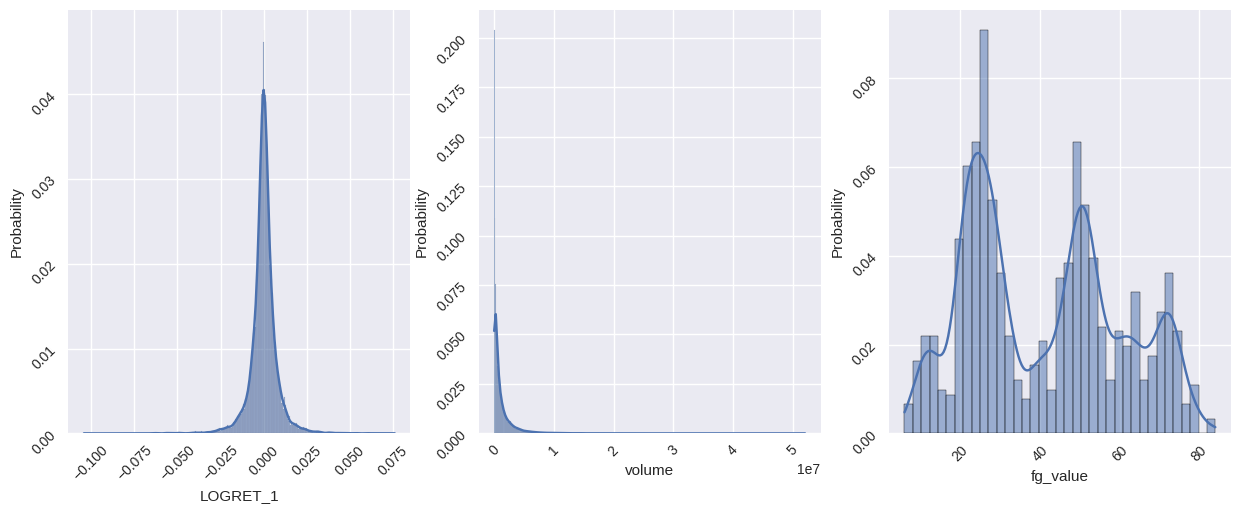

In [15]:
fig, axes = plt.subplots(1, 3)
sns.histplot(X, x='LOGRET_1', kde=True, ax=axes[0], stat='probability')
sns.histplot(X, x='volume', kde=True, ax=axes[1], stat='probability')
sns.histplot(X, x='fg_value', kde=True, ax=axes[2], stat='probability')
for ax in axes:
    ax.tick_params(labelrotation=45)
    # ax.set_xlabel('Date')
fig.set_figwidth(15)
plt.show()

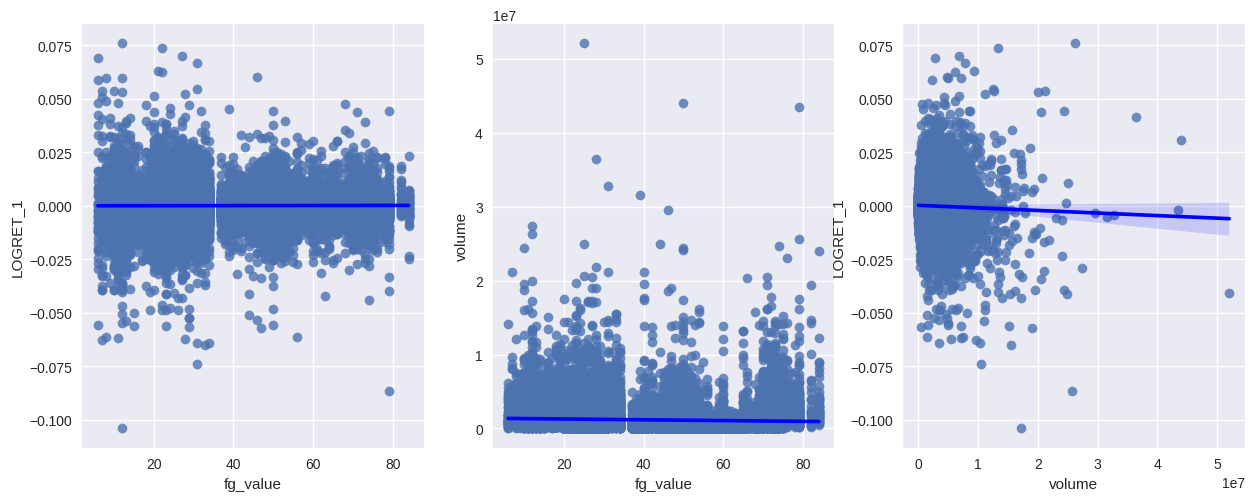

In [16]:
fig, axes = plt.subplots(1, 3)
sns.regplot(data=X, x='fg_value', y='LOGRET_1', ax=axes[0], line_kws=dict(color="b"))
sns.regplot(data=X, x='fg_value', y='volume', ax=axes[1], line_kws=dict(color="b"))
sns.regplot(data=X, x='volume', y='LOGRET_1', ax=axes[2], line_kws=dict(color="b"))
fig.set_figwidth(15)
plt.show()

Some observations from the above data:

- Return does not seem to be correlated with fg_value. However, higher fg_values (i.e. more greed in the index), seems to see the variance decrease (heteroscedasticity).
- There appears to be a slight negative correlation with fg_value and volume, indicating that less volume is traded during times of greed in the index. 
- Return does not have significatn outliers but volume does so would be a candidate for robust scaler.

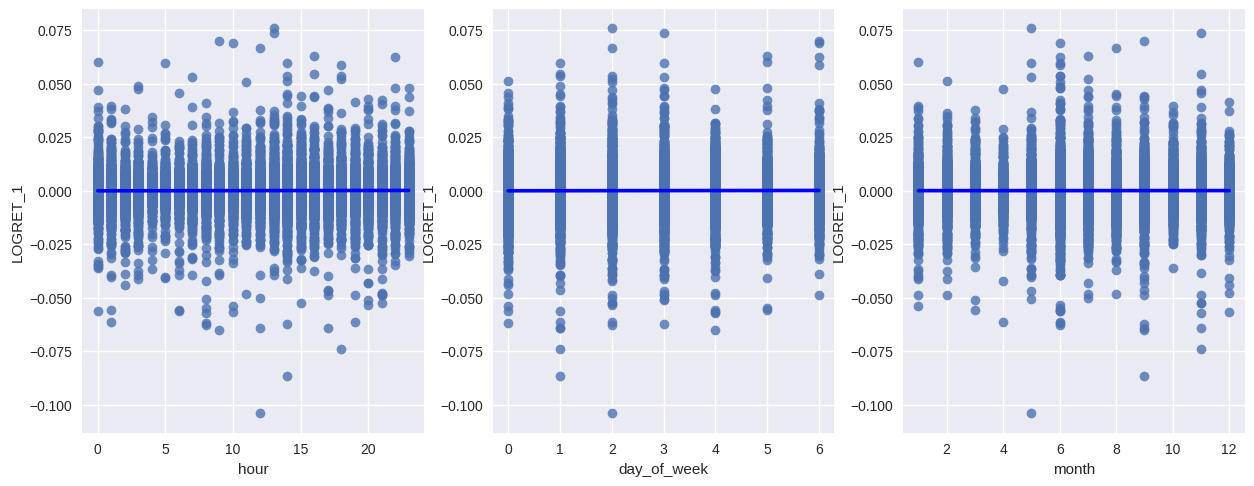

In [17]:
fig, axes = plt.subplots(1, 3)
sns.regplot(data=X, x='hour', y='LOGRET_1', ax=axes[0], line_kws=dict(color="b"))
sns.regplot(data=X, x='day_of_week', y='LOGRET_1', ax=axes[1], line_kws=dict(color="b"))
sns.regplot(data=X, x='month', y='LOGRET_1', ax=axes[2], line_kws=dict(color="b"))
fig.set_figwidth(15)
plt.show()

Some observations from the above data:

- There seems to be greater variation in returns around June over the prior two years indicating at least some seasonality. 

Some observations from the above data

- PVOL has outliers and would benefit from a robust scaler.
- CUBE features do not have particular outliers and should be fine with the min max scaler. 

In [18]:
# Checking for class imbalances
y.value_counts()

label
0    18359
1     3553
Name: count, dtype: int64

The above does indicate that there is quite a severe class imbalance in the data that will need to be addressed at the model building stage otherwise the model will likely underperform due to bias.

Next, I have examined the correlation between features. Collinearity between features is present and there are a number of features that will need cleaning before they can be used in the model. 

In [19]:
# One Hot Encoding of categorical data
encoder = OneHotEncoder(sparse_output=False)
onehot = encoder.fit_transform(X[['fg_value_classification', 'hour', 'day_of_week', 'month']])
feature_names = encoder.get_feature_names_out()
X[feature_names] = onehot
X.drop(['fg_value_classification', 'hour', 'day_of_week', 'month'], axis=1, inplace=True)

In [20]:
# Create a heatmap in Seaborn to see the features that are highly correlated and seek to remove them
X_cov = X.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(X_cov, cbar=True, xticklabels=True, yticklabels=True)
plt.tick_params(labelsize=5)
plt.title('Features Set Correlations')
plt.show()

It is clear from a pairplot on all non-zero features that there are some highly correlated features that can be remvoed from the feature set and that the data has a lot of points that need cleaning. Multicollinearity will be examined and removed in the next section using VIF. Features will then be further selected based on various methods discussed in more detail below. 

### Things to do above
- draw a picture of the proposed process

### Data Cleaning

- remove the columns with no data in them
- remove the columns with all the N/A in them
- revove columns with inf values in them

In [ ]:
# Checking where there are null values for more than a thousand rows and discarding column
cols_to_discard = df.isnull().sum()[df.isnull().sum() > 1000].index.values
df.drop(cols_to_discard, axis=1, inplace=True)
df.dropna(axis=0, inplace=True)
df.isnull().sum().sum()

0

In [ ]:
X = X.loc[:, (X != 0).any(axis=0)]
X.drop('VIDYA_14', axis=1, inplace=True)

### Feature Scaling
- discussion on scaling types
- table of which features will be scaled
- split into train and test first
- apply the scaler to each column as needed


In [ ]:
robust_df = appendix_2
robust_df['scaler'] = 'RobustScaler'
# robust_df.drop('outlier_count', axis=1, inplace=True)
min_max_df = pd.DataFrame()
min_max_df['feature'] = X.drop(robust_df['feature'], axis=1).columns
min_max_df['scaler'] = 'MinMaxScaler'
scalers_df = pd.concat([robust_df, min_max_df])
scalers_df.sort_values('feature', inplace=True)
scalers_df.reset_index(inplace=True, drop=True)
appendix_3 = scalers_df

,feature,scaler
0,ABER_ATR_5_15,MinMaxScaler
1,ABER_SG_5_15,MinMaxScaler
2,ABER_XG_5_15,MinMaxScaler
3,ABER_ZG_5_15,MinMaxScaler
4,ACCBL_20,MinMaxScaler
5,ACCBM_20,MinMaxScaler
6,ACCBU_20,MinMaxScaler
7,AD,MinMaxScaler
8,ADOSC_3_10,RobustScaler
9,ADXR_14_2,MinMaxScaler


### Feature Selection

- wrap the baseline model in scikit learn module so can use it in a pipeline
- remove correlated features (VIF?)
- rfe
- k best
- SHAP
- Baruta
- Give final list of features

### Deep Learning Model

- address class imbalance 
- base line model of 1 LSTM
- no dimensionality reduction vs umap reduction vs SOM reduction
- hypertune these models
- computational time for each model and details of what it was run on
- save this and all assets into tensorboard
- discuss the models


### Model Evaluation

- summary reports
- confusion matrix
- AUC reports
- computational time

### Backtesting

- pyfolio vs writing something myself?
- long only vs long hold
- long/short vs long hold

### Appendices

##### Appendix 1

In [ ]:
pd.options.display.float_format = '{:.02f}'.format
appendix_1['IQR'] = appendix_1['75%'] - appendix_1['25%']
appendix_1.sort_values('IQR', inplace=True, ascending=False)
appendix_1

,count,mean,std,min,25%,50%,75%,max,IQR
CUBEs_3.0_-1,21911.00,16758176456.01,21750574347.67,735971908.31,4129228672.96,6486993972.31,22707863578.47,113979716967.08,18578634905.52
CUBE_3.0_-1,21911.00,16758176456.01,21750574347.67,735971908.31,4129228672.96,6486993972.31,22707863578.47,113979716967.08,18578634905.52
PVOL,21912.00,3259424135.71,6956459688.52,0.00,198750474.06,831620961.09,3286123465.39,201146891543.67,3087372991.33
PVT,21911.00,-713401602.41,329062269.41,-1169705383.14,-925932417.37,-903879064.62,-577910676.27,312177807.01,348021741.10
OBV_max_2,21911.00,-303541282.50,180021636.09,-494654990.23,-452037744.92,-423979147.28,-117888629.50,96042697.94,334149115.42
OBV,21912.00,-304121851.26,179566632.71,-494861764.33,-452135143.58,-424476481.82,-118989361.96,96042697.94,333145781.62
OBVe_12,21901.00,-304161006.64,179481270.64,-494289975.60,-452128980.12,-424161046.62,-119028668.29,87951036.06,333100311.84
OBVe_4,21909.00,-304132740.27,179541467.02,-494648559.07,-452127350.54,-424483342.66,-119037305.14,92720292.60,333090045.40
OBV_min_2,21911.00,-304709763.07,179102229.66,-494861764.33,-452226693.36,-425030545.76,-119749618.97,92799212.77,332477074.38
AD,21912.00,490995213.43,163482618.63,-65475586.65,485047957.63,563620198.96,587219748.49,623009392.84,102171790.86


##### Appendix 2

In [ ]:
appendix_2

,feature,scaler
0,volume,RobustScaler
1,ADOSC_3_10,RobustScaler
2,DMN_14,RobustScaler
3,AO_5_34,RobustScaler
4,BBB_5_2.0,RobustScaler
5,CFO_9,RobustScaler
6,DPO_20,RobustScaler
7,EFI_13,RobustScaler
8,EOM_14_100000000,RobustScaler
9,BULLP_13,RobustScaler


##### Appendix 3

In [ ]:
appendix_3

NameError: name 'appendix_3' is not defined